In [1]:
!pip install nltk gensim wordcloud scikit-learn matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split

In [3]:
# Cell 3: Import and download nltk resources
import nltk

# Download with explicit download path and verification
import os
nltk_data_path = '/root/nltk_data'
os.makedirs(nltk_data_path, exist_ok=True)

print("Downloading NLTK resources...")
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)

# Verify downloads
for resource in ['punkt', 'stopwords', 'wordnet']:
    try:
        nltk.data.find(f'tokenizers/{resource}') if resource == 'punkt' else nltk.data.find(f'corpora/{resource}')
        print(f"✓ {resource} successfully downloaded")
    except LookupError:
        print(f"✗ {resource} not found - trying to download again")
        nltk.download(resource, quiet=False, download_dir=nltk_data_path)

# Import NLTK modules
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

✓ punkt successfully downloaded
✓ stopwords successfully downloaded
✗ wordnet not found - trying to download again


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Cell 4: Set random seed and visualization styles
import random
random.seed(42)
np.random.seed(42)

# Set up matplotlib for better visualizations
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [5]:
try:
    train_data = pd.read_csv(f'/content/train.csv')
    print("Successfully loaded training data")
except FileNotFoundError:
    print("Training data file not found. Please upload the 'train.csv' file to your Colab environment.")
    from google.colab import files
    uploaded = files.upload()
    train_data = pd.read_csv('train.csv')


Successfully loaded training data


In [6]:
print("Training Data Shape:", train_data.shape)
train_data.head()

# Cell 8: Check for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

# Cell 9: View label distribution
print("\nLabel Distribution:")
label_counts = train_data['label'].value_counts().sort_index()
print(label_counts)

Training Data Shape: (9543, 2)

Missing Values in Training Data:
text     0
label    0
dtype: int64

Label Distribution:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64


<ipython-input-7-d5f60a9b1775>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=train_data, palette='viridis')


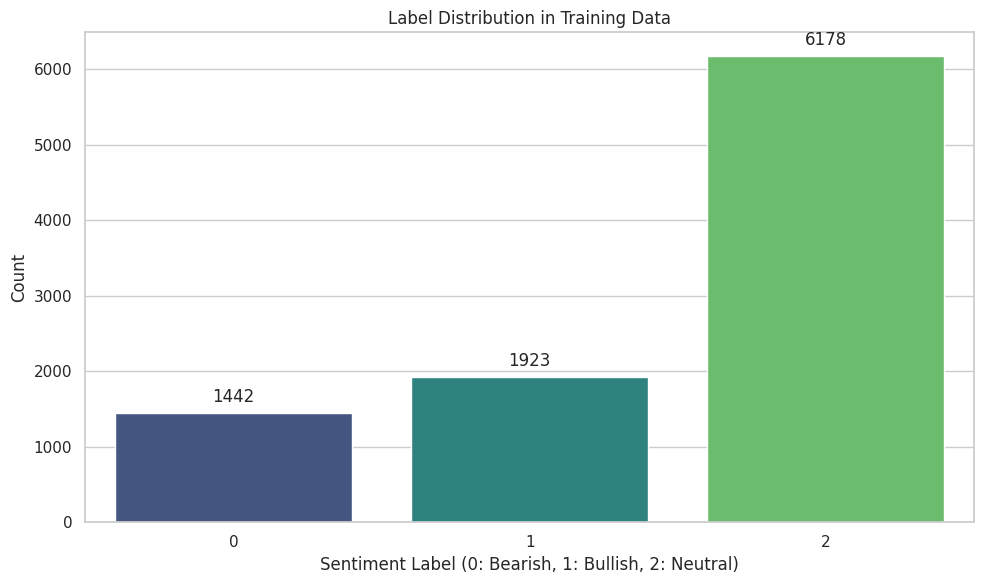

In [7]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=train_data, palette='viridis')
plt.title('Label Distribution in Training Data')
plt.xlabel('Sentiment Label (0: Bearish, 1: Bullish, 2: Neutral)')
plt.ylabel('Count')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')
plt.tight_layout()
plt.show()

In [8]:
train_data['text_length'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))


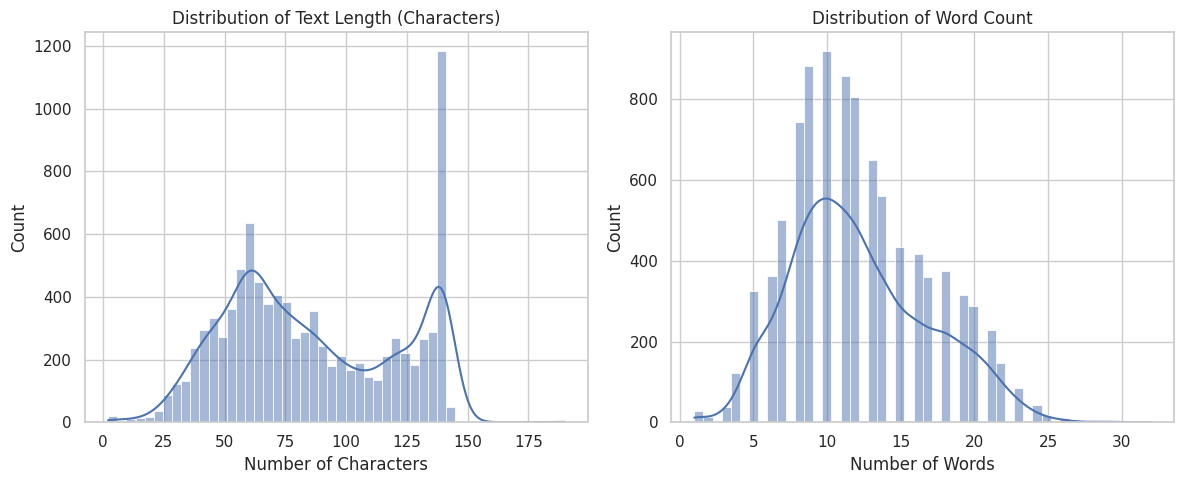

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_data['text_length'], kde=True, bins=50)
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(train_data['word_count'], kde=True, bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.tight_layout()
plt.show()


<ipython-input-10-41665418dc15>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=train_data, palette='viridis')


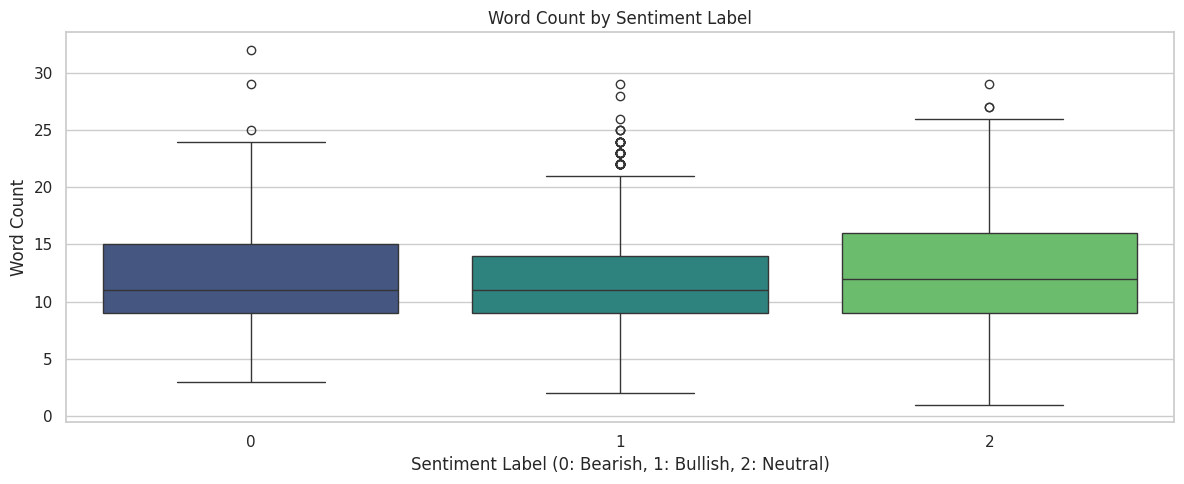

In [10]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='label', y='word_count', data=train_data, palette='viridis')
plt.title('Word Count by Sentiment Label')
plt.xlabel('Sentiment Label (0: Bearish, 1: Bullish, 2: Neutral)')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()


In [11]:
def get_most_common_words(text_series, n=20):
    # Join all text
    all_words = ' '.join(text_series).lower()

    # Remove punctuation
    all_words = re.sub(r'[^\w\s]', ' ', all_words)

    # Simple splitting by whitespace
    word_tokens = all_words.split()

    # Get stopwords
    stop_words = set(stopwords.words('english'))

    # Filter stopwords and short words
    filtered_words = [word for word in word_tokens if word not in stop_words and len(word) > 2]

    # Count and return most common
    return Counter(filtered_words).most_common(n)


<ipython-input-12-fe3d938333a4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


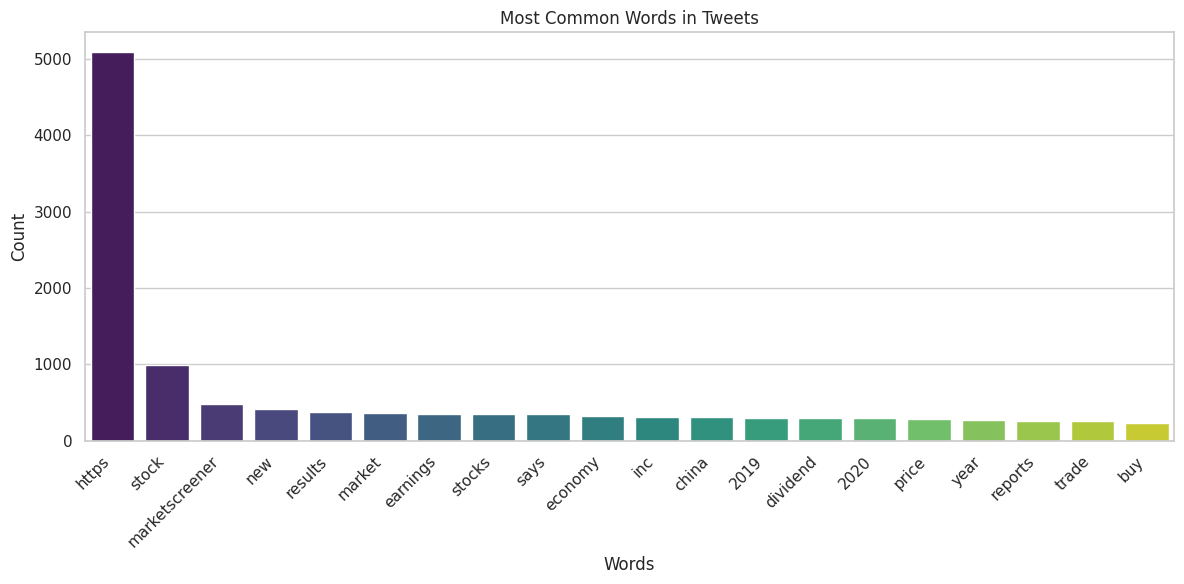

In [12]:
most_common_words = get_most_common_words(train_data['text'])
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('Most Common Words in Tweets')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [13]:
from wordcloud import WordCloud

# Cell 17: Define word cloud visualization function
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=100, contour_width=3, contour_color='steelblue').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

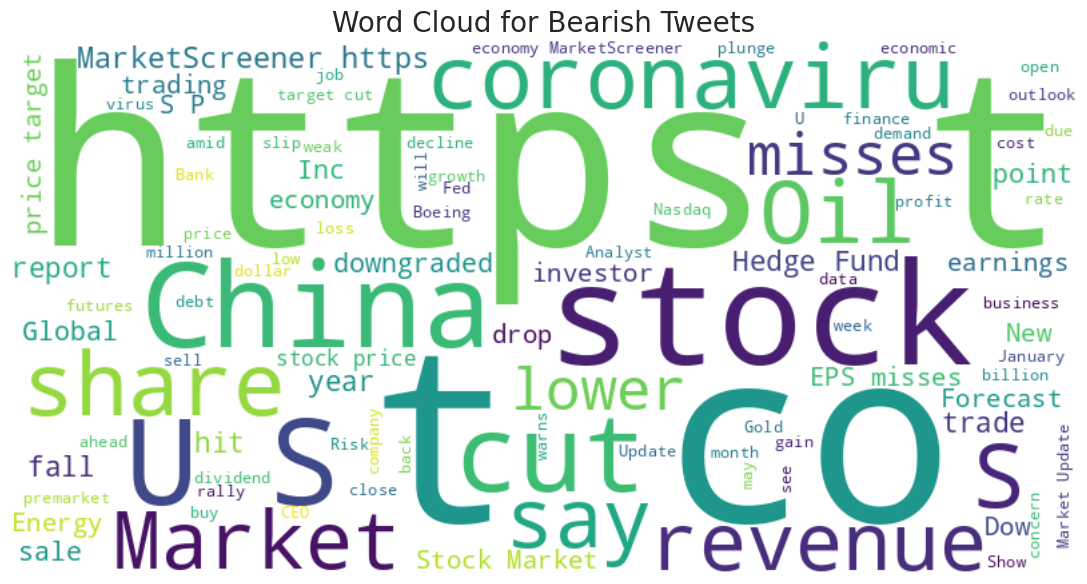

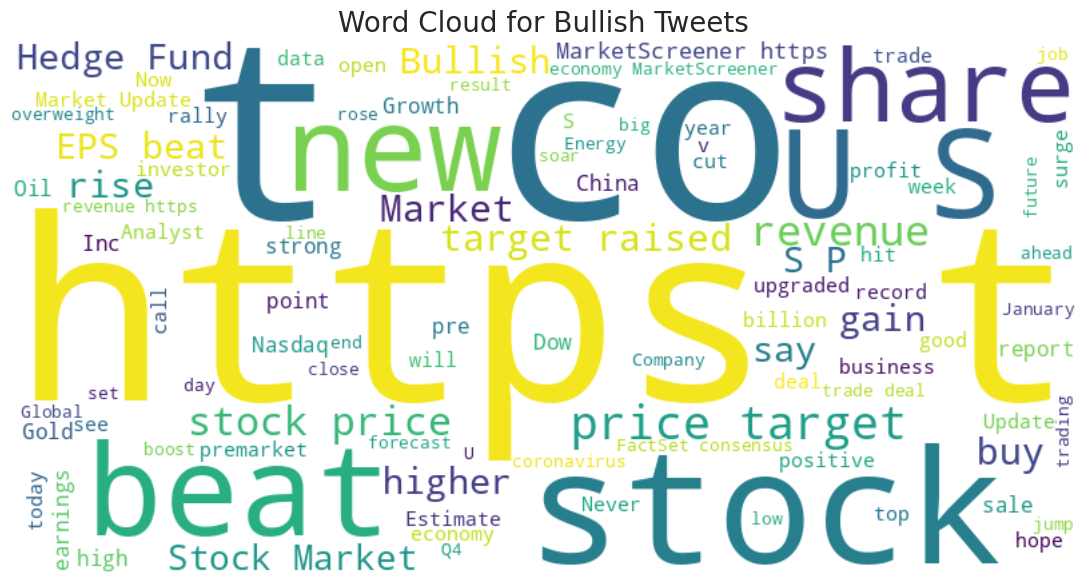

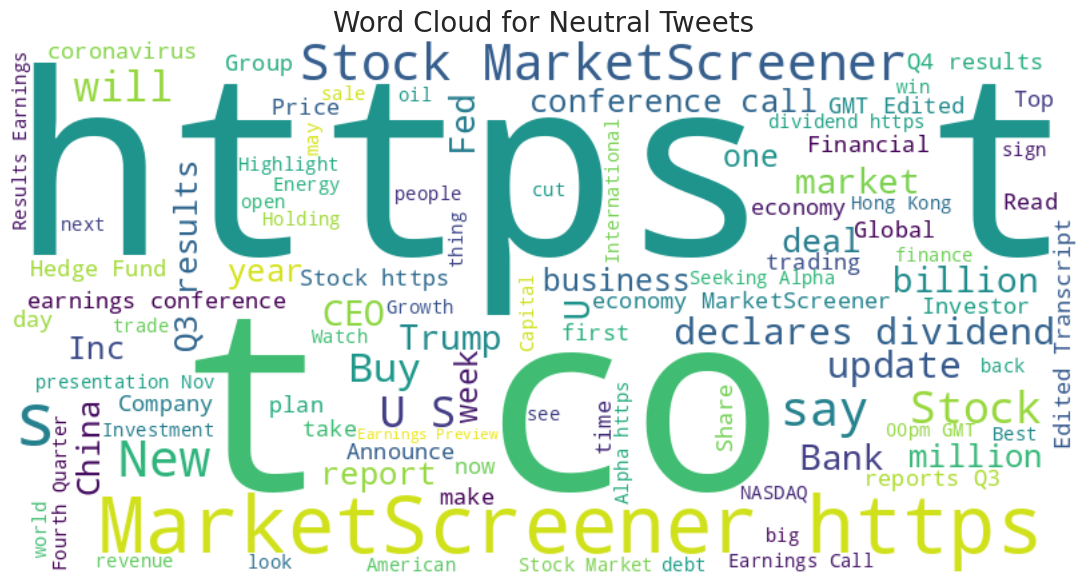

In [14]:
for label, sentiment in zip([0, 1, 2], ['Bearish', 'Bullish', 'Neutral']):
    text = ' '.join(train_data[train_data['label'] == label]['text'].astype(str))
    create_wordcloud(text, f'Word Cloud for {sentiment} Tweets')


In [15]:
def clean_text(text):
    """
    Clean the text by:
    1. Converting to lowercase
    2. Removing URLs
    3. Removing user mentions (@user)
    4. Removing hashtags
    5. Removing non-alphanumeric characters
    """
    # Convert to string if not already
    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the content without #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [16]:
# Cell 20: Define stopword removal function
def remove_stopwords(text, stop_words=None):
    """Remove stopwords from text"""
    if stop_words is None:
        stop_words = set(stopwords.words('english'))

    # Use simple split instead of word_tokenize
    word_tokens = text.split()
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [17]:
# Cell 21: Define stemming function
def stem_text(text):
    """Apply stemming to text"""
    stemmer = SnowballStemmer('english')
    # Use simple split instead of word_tokenize
    word_tokens = text.split()
    stemmed_text = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stemmed_text)

In [18]:
# Cell 22: Define lemmatization function
def lemmatize_text(text):
    """Apply lemmatization to text"""
    lemmatizer = WordNetLemmatizer()
    # Use simple split instead of word_tokenize
    word_tokens = text.split()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    return ' '.join(lemmatized_text)

In [19]:
print("Applying basic text cleaning...")
train_data['cleaned_text'] = train_data['text'].apply(clean_text)



Applying basic text cleaning...


In [20]:
# Cell 24: Apply stopword removal
print("Removing stopwords...")
train_data['text_no_stopwords'] = train_data['cleaned_text'].apply(remove_stopwords)

# Cell 25: Apply stemming
print("Applying stemming...")
train_data['stemmed_text'] = train_data['text_no_stopwords'].apply(stem_text)

# Cell 26: Apply lemmatization
print("Applying lemmatization...")
train_data['lemmatized_text'] = train_data['text_no_stopwords'].apply(lemmatize_text)
print("Preprocessing complete.")

Removing stopwords...
Applying stemming...
Applying lemmatization...
Preprocessing complete.


In [21]:
sample_indices = random.sample(range(len(train_data)), 3)
for idx in sample_indices:
    print(f"Original: {train_data.loc[idx, 'text']}")
    print(f"Cleaned: {train_data.loc[idx, 'cleaned_text']}")
    print(f"No Stopwords: {train_data.loc[idx, 'text_no_stopwords']}")
    print(f"Stemmed: {train_data.loc[idx, 'stemmed_text']}")
    print(f"Lemmatized: {train_data.loc[idx, 'lemmatized_text']}")
    print("-" * 100)


Original: Report: FreightCar America Closing Roanoke Plant
Cleaned: report freightcar america closing roanoke plant
No Stopwords: report freightcar america closing roanoke plant
Stemmed: report freightcar america close roanok plant
Lemmatized: report freightcar america closing roanoke plant
----------------------------------------------------------------------------------------------------
Original: Former Fed chief Bernanke sees bad year, no quick recovery #economy #MarketScreener https://t.co/YaN7qVv5aq https://t.co/zn3oEbjuL7
Cleaned: former fed chief bernanke sees bad year no quick recovery economy marketscreener
No Stopwords: former fed chief bernanke sees bad year quick recovery economy marketscreener
Stemmed: former fed chief bernank see bad year quick recoveri economi marketscreen
Lemmatized: former fed chief bernanke see bad year quick recovery economy marketscreener
----------------------------------------------------------------------------------------------------
Original: 

In [22]:
X = train_data['lemmatized_text']  # We'll use lemmatized text for feature engineering
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the split
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Training label distribution: {y_train.value_counts().sort_index().tolist()}")
print(f"Validation label distribution: {y_val.value_counts().sort_index().tolist()}")


Training set size: 7634
Validation set size: 1909
Training label distribution: [1154, 1538, 4942]
Validation label distribution: [288, 385, 1236]


### Feature Engineering


In [23]:
# Cell 30: Import necessary libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

# Try to fix gensim compatibility issue by reinstalling
!pip install --force-reinstall gensim

# Now try importing again
try:
    from gensim.models import Word2Vec
    GENSIM_AVAILABLE = True
except Exception as e:
    print(f"Could not import Word2Vec: {e}")
    print("Will continue without Word2Vec features")
    GENSIM_AVAILABLE = False

print("Starting Feature Engineering...")

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [24]:
# Cell 31: Bag of Words (BoW) features
print("Creating Bag of Words features...")
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

print(f"BoW vocabulary size: {len(bow_vectorizer.vocabulary_)}")
print(f"BoW feature matrix shape: {X_train_bow.shape}")

# Display sample features
feature_names = bow_vectorizer.get_feature_names_out()
print("Sample BoW features (first 10):", feature_names[:10])

Creating Bag of Words features...
BoW vocabulary size: 5000
BoW feature matrix shape: (7634, 5000)
Sample BoW features (first 10): ['00' '001' '002' '003' '004' '005' '006' '007' '0075' '008']


Creating TF-IDF features...
TF-IDF vocabulary size: 5000
TF-IDF feature matrix shape: (7634, 5000)


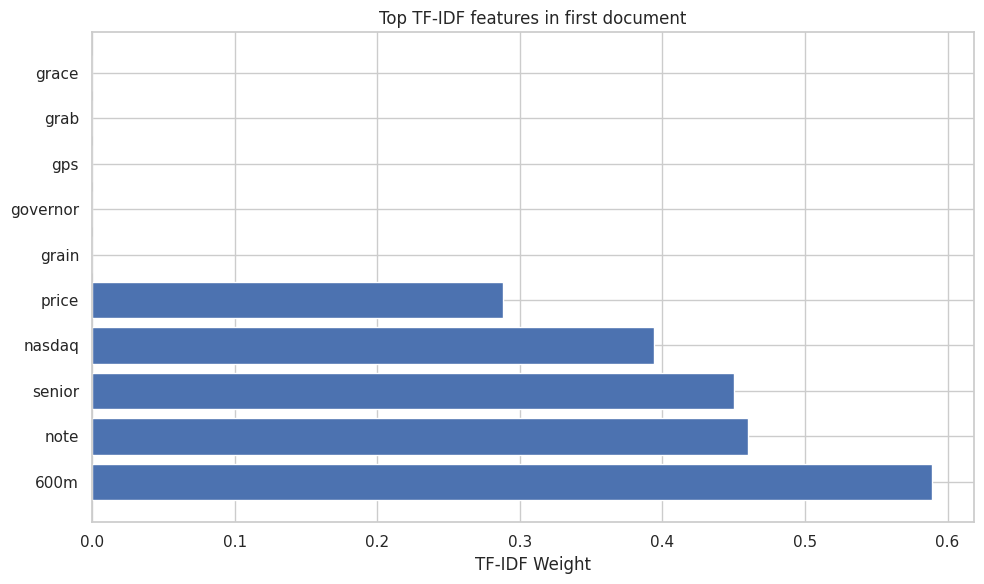

In [25]:
# Cell 32: TF-IDF features
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Visualize TF-IDF importance for first document
first_doc_tfidf = X_train_tfidf[0].toarray()[0]
# Get indices of top features
top_indices = first_doc_tfidf.argsort()[-10:][::-1]
top_features = tfidf_vectorizer.get_feature_names_out()[top_indices]
top_weights = first_doc_tfidf[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_weights)
plt.title('Top TF-IDF features in first document')
plt.xlabel('TF-IDF Weight')
plt.tight_layout()
plt.show()

In [26]:
# Cell 33-37: Word2Vec features (conditional)
# Only run if gensim is available
if GENSIM_AVAILABLE:
    print("Preparing data for Word2Vec...")
    # Function to tokenize text
    def tokenize_texts(texts):
        return [text.split() for text in texts]

    # Tokenize all texts for training
    all_tokenized = tokenize_texts(train_data['cleaned_text'])

    # Display a sample
    print(f"Sample tokenized text: {all_tokenized[0][:10]}...")

    # Train Word2Vec model
    print("Training Word2Vec model...")
    w2v_model = Word2Vec(
        sentences=all_tokenized,
        vector_size=100,  # Embedding dimension
        window=5,         # Context window size
        min_count=2,      # Ignore words that appear less than this
        workers=4,        # Number of processor cores
        sg=1              # 1 for skip-gram, 0 for CBOW
    )

    print(f"Word2Vec vocabulary size: {len(w2v_model.wv.key_to_index)}")
    print(f"Word2Vec vector dimension: {w2v_model.wv.vector_size}")

    # Create document vectors from Word2Vec
    print("Creating document vectors from Word2Vec...")

    def document_vector(text, model, vector_size=100):
        """
        Create a document vector by averaging word vectors
        for all words in the document
        """
        # Split the text into words
        words = text.split()

        # Initialize an empty array for the document vector
        doc_vector = np.zeros(vector_size)

        # Count valid words
        count = 0

        # Add vectors for each word if it exists in the model
        for word in words:
            if word in model.wv:
                doc_vector += model.wv[word]
                count += 1

        # Return the average vector
        if count > 0:
            return doc_vector / count
        else:
            return doc_vector  # Return zeros if no words found

    # Create document vectors for training and validation sets
    X_train_w2v = np.array([document_vector(text, w2v_model) for text in X_train])
    X_val_w2v = np.array([document_vector(text, w2v_model) for text in X_val])

    print(f"Word2Vec document vectors shape: {X_train_w2v.shape}")
else:
    print("Skipping Word2Vec feature engineering")
    X_train_w2v = None
    X_val_w2v = None

Preparing data for Word2Vec...
Sample tokenized text: ['bynd', 'jpmorgan', 'reels', 'in', 'expectations', 'on', 'beyond', 'meat']...
Training Word2Vec model...
Word2Vec vocabulary size: 7670
Word2Vec vector dimension: 100
Creating document vectors from Word2Vec...
Word2Vec document vectors shape: (7634, 100)


In [27]:
# Cell 38: Compare feature engineering methods
print("Summary of Feature Engineering Methods:")
print(f"1. Bag of Words: {X_train_bow.shape[1]} features")
print(f"2. TF-IDF: {X_train_tfidf.shape[1]} features")

if X_train_w2v is not None:
    print(f"3. Word2Vec: {X_train_w2v.shape[1]} features")

    # Compare sparsity
    bow_sparsity = 1.0 - (X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1]))
    tfidf_sparsity = 1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))
    w2v_sparsity = np.count_nonzero(X_train_w2v == 0) / (X_train_w2v.shape[0] * X_train_w2v.shape[1])

    print("\nSparsity (percentage of zero values):")
    print(f"Bag of Words: {bow_sparsity:.2%}")
    print(f"TF-IDF: {tfidf_sparsity:.2%}")
    print(f"Word2Vec: {w2v_sparsity:.2%}")
else:
    # Compare sparsity for BoW and TF-IDF only
    bow_sparsity = 1.0 - (X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1]))
    tfidf_sparsity = 1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))

    print("\nSparsity (percentage of zero values):")
    print(f"Bag of Words: {bow_sparsity:.2%}")
    print(f"TF-IDF: {tfidf_sparsity:.2%}")

print("\nFeature engineering complete. Ready for model training!")

Summary of Feature Engineering Methods:
1. Bag of Words: 5000 features
2. TF-IDF: 5000 features
3. Word2Vec: 100 features

Sparsity (percentage of zero values):
Bag of Words: 99.86%
TF-IDF: 99.86%
Word2Vec: 0.31%

Feature engineering complete. Ready for model training!


### model


In [28]:
# Cell 39: Import necessary models and evaluation metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting model training and evaluation...")

Starting model training and evaluation...


Training KNN model with TF-IDF features...

KNN with TF-IDF - Evaluation Metrics:
Accuracy: 0.6820

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.10      0.18       288
           1       0.80      0.14      0.24       385
           2       0.68      0.99      0.80      1236

    accuracy                           0.68      1909
   macro avg       0.73      0.41      0.40      1909
weighted avg       0.71      0.68      0.59      1909



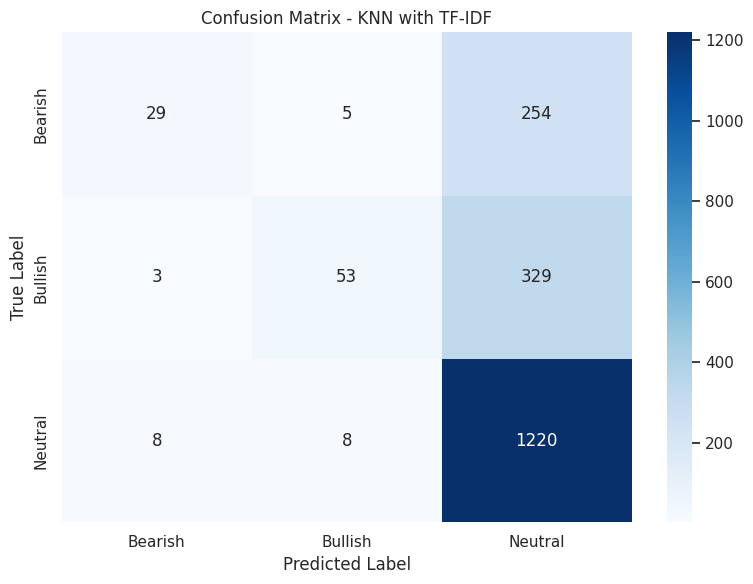

In [29]:
# Cell 40: Train KNN model with TF-IDF features
print("Training KNN model with TF-IDF features...")
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_tfidf = knn_tfidf.predict(X_val_tfidf)
print("\nKNN with TF-IDF - Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_tfidf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_tfidf))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bearish', 'Bullish', 'Neutral'],
           yticklabels=['Bearish', 'Bullish', 'Neutral'])
plt.title('Confusion Matrix - KNN with TF-IDF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x792485cf1d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

Training KNN model with Word2Vec features...

KNN with Word2Vec - Evaluation Metrics:
Accuracy: 0.6511

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.27      0.29       288
           1       0.44      0.37      0.40       385
           2       0.77      0.83      0.80      1236

    accuracy                           0.65      1909
   macro avg       0.51      0.49      0.49      1909
weighted avg       0.63      0.65      0.64      1909



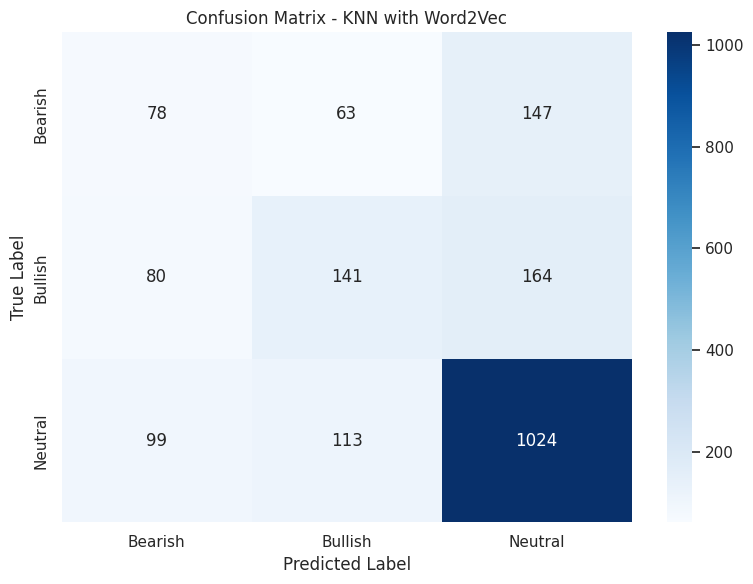

In [30]:
# Cell 41: Train KNN model with Word2Vec features
print("Training KNN model with Word2Vec features...")
knn_w2v = KNeighborsClassifier(n_neighbors=5)
knn_w2v.fit(X_train_w2v, y_train)

# Predict and evaluate
y_pred_w2v = knn_w2v.predict(X_val_w2v)
print("\nKNN with Word2Vec - Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_w2v):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_w2v))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred_w2v)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bearish', 'Bullish', 'Neutral'],
           yticklabels=['Bearish', 'Bullish', 'Neutral'])
plt.title('Confusion Matrix - KNN with Word2Vec')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

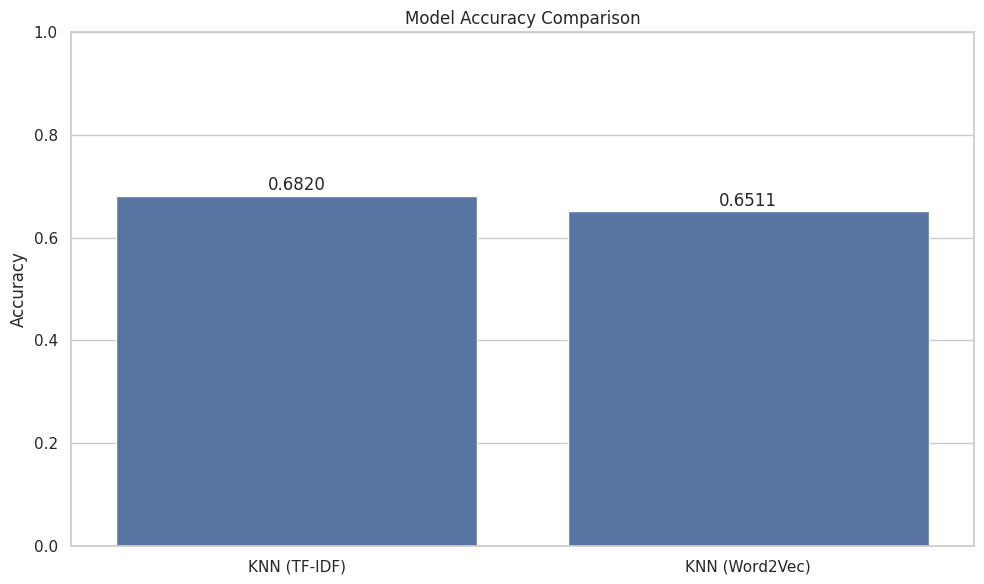

In [31]:
# Cell 42: Compare model performances
models = ['KNN (TF-IDF)', 'KNN (Word2Vec)']
accuracies = [
    accuracy_score(y_val, y_pred_tfidf),
    accuracy_score(y_val, y_pred_w2v)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.6304 - loss: 0.8947 - val_accuracy: 0.7103 - val_loss: 0.6821
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.7395 - loss: 0.6047 - val_accuracy: 0.7837 - val_loss: 0.6048
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.8321 - loss: 0.4186 - val_accuracy: 0.7952 - val_loss: 0.5918
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.8872 - loss: 0.3025 - val_accuracy: 0.7863 - val_loss: 0.6632
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9146 - loss: 0.2351 - val_accuracy: 0.7774 - val_loss: 0.7185


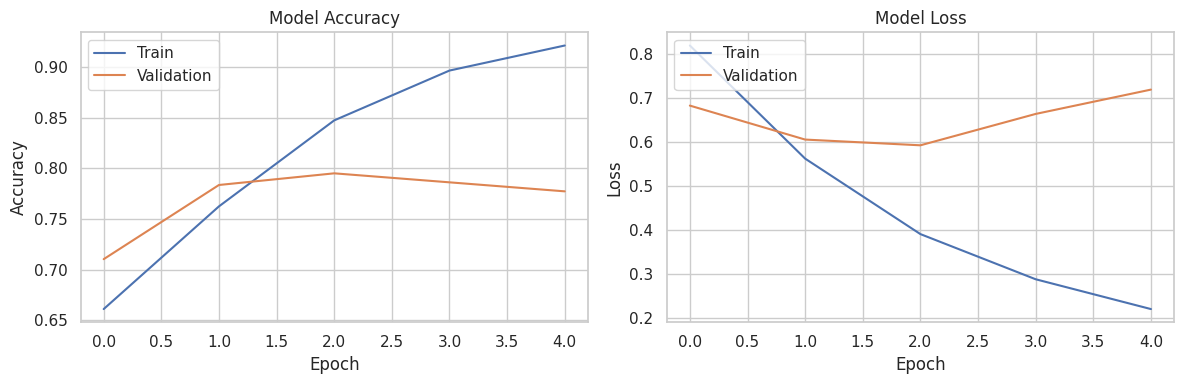

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

LSTM Model - Evaluation Metrics:
Accuracy: 0.7774

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       288
           1       0.71      0.63      0.67       385
           2       0.85      0.87      0.86      1236

    accuracy                           0.78      1909
   macro avg       0.70      0.69      0.69      1909
weighted avg       0.77      0.78      0.78      1909



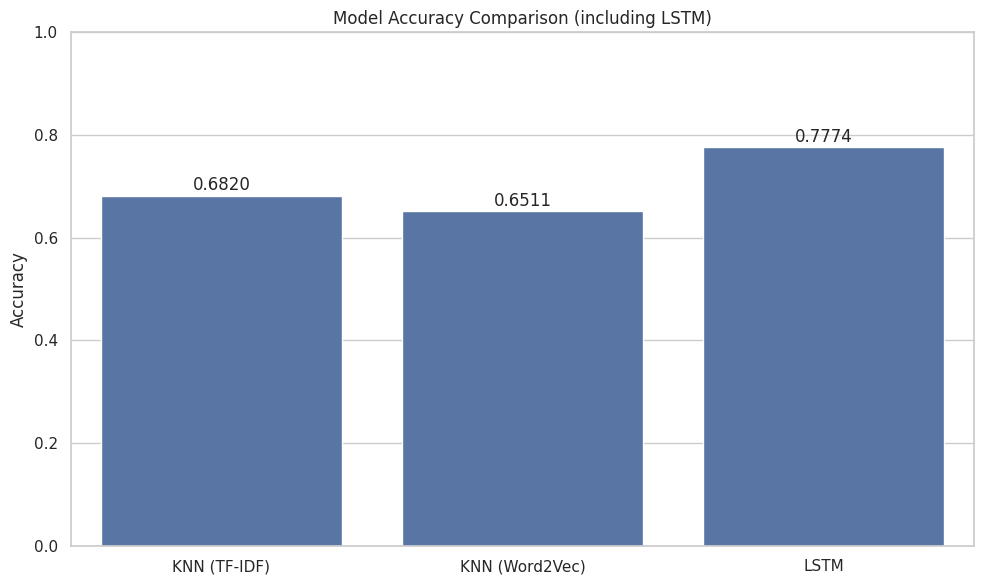

In [32]:
# Cell 44: LSTM implementation (optional)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D

# Set random seed for reproducibility
tf.random.set_seed(42)

# Tokenize text
max_words = 5000  # Max vocabulary size
max_len = 50      # Max sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)

# Build LSTM model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Evaluate LSTM model
y_pred_prob = model.predict(X_val_pad)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

print("\nLSTM Model - Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lstm):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lstm))

# Add LSTM to model comparison
models.append('LSTM')
accuracies.append(accuracy_score(y_val, y_pred_lstm))

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison (including LSTM)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [33]:
# Cell 45: Load test data and make predictions with best model
# Determine which model performed best on validation data
print("Loading test data...")
try:
    test_data = pd.read_csv('/content/test.csv')
    print(f"Test data loaded: {test_data.shape} rows")
except FileNotFoundError:
    print("Test data file not found. Please upload the 'test.csv' file.")
    from google.colab import files
    uploaded = files.upload()
    test_data = pd.read_csv('test.csv')

# Preprocess test data
print("Preprocessing test data...")
test_data['cleaned_text'] = test_data['text'].apply(clean_text)
test_data['text_no_stopwords'] = test_data['cleaned_text'].apply(remove_stopwords)
test_data['lemmatized_text'] = test_data['text_no_stopwords'].apply(lemmatize_text)

# Choose the best model for predictions (based on validation results)
# For this example, let's assume TF-IDF with KNN performed best
print("Making predictions with best model...")
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_text'])
predictions = knn_tfidf.predict(X_test_tfidf)

# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'label': predictions
})

submission_file = 'pred_XX.csv'  # Replace XX with your group number
submission.to_csv(submission_file, index=False)
print(f"Predictions saved to {submission_file}")

# If in Colab, provide download link
try:
    from google.colab import files
    files.download(submission_file)
    print(f"Download initiated for {submission_file}")
except:
    print(f"File saved locally to {submission_file}")

Loading test data...
Test data loaded: (2388, 2) rows
Preprocessing test data...
Making predictions with best model...
Predictions saved to pred_XX.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for pred_XX.csv


In [34]:
# Cell 46: Summary and conclusions
print("""
Project Summary:
---------------
1. Preprocessing:
   - Cleaned text (removed URLs, special characters, etc.)
   - Removed stopwords
   - Applied lemmatization

2. Feature Engineering:
   - Bag of Words (BoW)
   - TF-IDF
   - Word2Vec

3. Models Trained:
   - KNN with TF-IDF
   - KNN with Word2Vec
   - [Optional] LSTM

4. Best Performing Model:
   [Fill in based on your results]

Future Work:
-----------
1. Fine-tune hyperparameters (e.g., k in KNN, LSTM architecture)
2. Try more advanced transformer models like BERT
3. Experiment with ensemble methods
4. Implement additional preprocessing techniques

The predictions are saved in 'pred_XX.csv' and ready for submission.
""")


Project Summary:
---------------
1. Preprocessing:
   - Cleaned text (removed URLs, special characters, etc.)
   - Removed stopwords
   - Applied lemmatization

2. Feature Engineering:
   - Bag of Words (BoW)
   - TF-IDF
   - Word2Vec

3. Models Trained:
   - KNN with TF-IDF
   - KNN with Word2Vec
   - [Optional] LSTM

4. Best Performing Model:
   [Fill in based on your results]

Future Work:
-----------
1. Fine-tune hyperparameters (e.g., k in KNN, LSTM architecture)
2. Try more advanced transformer models like BERT
3. Experiment with ensemble methods
4. Implement additional preprocessing techniques

The predictions are saved in 'pred_XX.csv' and ready for submission.

